In [1]:
# https://github.com/pytorch/pytorch/issues/13883
import torch.multiprocessing as mp

if __name__ == '__main__':
    mp.set_start_method('forkserver')

In [2]:
import argparse
import collections
import cProfile
import hashlib
import itertools
import math
import os
import pstats
import re
import shutil
import signal
import statistics
import string
from collections import defaultdict
from datetime import datetime
from io import StringIO

import matplotlib
import torch
import torch.distributed as dist
import torchaudio
from matplotlib import pyplot as plt
from tabulate import tabulate
from torch import nn, topk
from torch.optim import SGD, Adadelta, Adam
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchaudio.datasets import LIBRISPEECH, SPEECHCOMMANDS
from torchaudio.transforms import MFCC, Resample
from tqdm.notebook import tqdm as tqdm

print("start time: {}".format(str(datetime.now())), flush=True)

try:
    %matplotlib inline
    in_notebook = True
except NameError:
    matplotlib.use("Agg")
    in_notebook = False
    
# Empty CUDA cache
torch.cuda.empty_cache()

# Profiling performance
pr = cProfile.Profile()
pr.enable()

start time: 2020-04-16 16:07:15.738187


In [3]:
# Create argument parser
parser = argparse.ArgumentParser()

parser.add_argument('--workers', default=0, type=int,
                    metavar='N', help='number of data loading workers')
parser.add_argument('--resume', default='', type=str,
                    metavar='PATH', help='path to latest checkpoint')

parser.add_argument('--epochs', default=200, type=int,
                    metavar='N', help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int,
                    metavar='N', help='manual epoch number')
parser.add_argument('--print-freq', default=10, type=int,
                    metavar='N', help='print frequency in epochs')

parser.add_argument('--arch', metavar='ARCH', default='wav2letter',
                    choices=["wav2letter", "lstm"], help='model architecture')
parser.add_argument('--batch-size', default=64, type=int,
                    metavar='N', help='mini-batch size')
parser.add_argument('--learning-rate', default=1., type=float,
                    metavar='LR', help='initial learning rate')
# parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
parser.add_argument('--weight-decay', default=1e-5,
                    type=float, metavar='W', help='weight decay')
parser.add_argument("--eps", metavar='EPS', type=float, default=1e-8)
parser.add_argument("--rho", metavar='RHO', type=float, default=.95)

parser.add_argument('--world-size', default=1, type=int,
                    help='number of distributed processes')
parser.add_argument('--dist-url', default='tcp://224.66.41.62:23456',
                    type=str, help='url used to set up distributed training')
parser.add_argument('--dist-backend', default='nccl',
                    type=str, help='distributed backend')
parser.add_argument('--dataset', default='librispeech', type=str)
parser.add_argument('--gradient', action="store_true")
parser.add_argument('--jit', action="store_true")

if in_notebook:
    args, _ = parser.parse_known_args()
else:
    args = parser.parse_args()

Namespace(arch='wav2letter', batch_size=64, dataset='librispeech', dist_backend='nccl', dist_url='tcp://224.66.41.62:23456', epochs=200, eps=1e-08, gradient=False, jit=False, learning_rate=1.0, print_freq=10, resume='', rho=0.95, start_epoch=0, weight_decay=1e-05, workers=0, world_size=1)


In [4]:
args.arch = "lstm"
args.learning_rate = 0.001

# Checkpoint

In [5]:
MAIN_PID = os.getpid()
CHECKPOINT_filename = args.resume if args.resume else 'checkpoint.pth.tar'
CHECKPOINT_tempfile = CHECKPOINT_filename + '.temp'
HALT_filename = CHECKPOINT_filename + '.HALT'
SIGNAL_RECEIVED = False

# HALT file is used as a sign of job completion.
# Make sure no HALT file left from previous runs.
if os.path.isfile(HALT_filename):
    os.remove(HALT_filename)

# Remove CHECKPOINT_tempfile, in case the signal arrives in the
# middle of copying from CHECKPOINT_tempfile to CHECKPOINT_filename
if os.path.isfile(CHECKPOINT_tempfile):
    os.remove(CHECKPOINT_tempfile)


def SIGTERM_handler(a, b):
    print('received sigterm')
    pass


def signal_handler(a, b):
    global SIGNAL_RECEIVED
    print('Signal received', a, datetime.now().strftime(
        "%y%m%d.%H%M%S"), flush=True)
    SIGNAL_RECEIVED = True

    # If HALT file exists, which means the job is done, exit peacefully.
    if os.path.isfile(HALT_filename):
        print('Job is done, exiting')
        exit(0)

    return


def trigger_job_requeue():
    # Submit a new job to resume from checkpoint.
    if os.path.isfile(CHECKPOINT_filename) and \
       os.environ['SLURM_PROCID'] == '0' and \
       os.getpid() == MAIN_PID:
        print('pid: ', os.getpid(), ' ppid: ', os.getppid(), flush=True)
        print('time is up, back to slurm queue', flush=True)
        command = 'scontrol requeue ' + os.environ['SLURM_JOB_ID']
        print(command)
        if os.system(command):
            raise RuntimeError('requeue failed')
        print('New job submitted to the queue', flush=True)
    exit(0)


# Install signal handler
signal.signal(signal.SIGUSR1, signal_handler)
signal.signal(signal.SIGTERM, SIGTERM_handler)
print('Signal handler installed', flush=True)


def save_checkpoint(state, is_best, filename=CHECKPOINT_filename):
    """
    Save the model to a temporary file first,
    then copy it to filename, in case the signal interrupts
    the torch.save() process.
    """
    if not args.distributed or os.environ['SLURM_PROCID'] == '0':
        torch.save(state, CHECKPOINT_tempfile)
        if os.path.isfile(CHECKPOINT_tempfile):
            os.rename(CHECKPOINT_tempfile, filename)
        if is_best:
            shutil.copyfile(filename, 'model_best.pth.tar')
        print("Checkpoint: saved")

Signal handler installed


# Distributed

In [6]:
# Use #nodes as world_size
if 'SLURM_NNODES' in os.environ:
    args.world_size = int(os.environ['SLURM_NNODES'])

args.distributed = args.world_size > 1

if args.distributed:
    os.environ['RANK'] = os.environ['SLURM_PROCID']
    os.environ['WORLD_SIZE'] = str(args.world_size)
    print('in distributed', os.environ['RANK'],
          os.environ['MASTER_ADDR'], os.environ['MASTER_PORT'], flush=True)
    dist.init_process_group(backend=args.dist_backend,
                            init_method=args.dist_url, world_size=args.world_size)

    print('init process', flush=True)

# Parameters

In [ ]:
if not args.distributed or os.environ['SLURM_PROCID'] == '0':
    print(args, flush=True)

In [7]:
audio_backend = "soundfile"
torchaudio.set_audio_backend(audio_backend)

root = "/datasets01/"
folder_in_archive = "librispeech/062419/"

device = "cuda" if torch.cuda.is_available() else "cpu"
num_devices = torch.cuda.device_count()
# num_devices = 1
print(num_devices, "GPUs", flush=True)

# max number of sentences per batch
batch_size = args.batch_size
# batch_size = 2048
# batch_size = 512
# batch_size = 256
# batch_size = 64
# batch_size = 1

training_percentage = 90.
validation_percentage = 5.

data_loader_training_params = {
    "num_workers": args.workers,
    "pin_memory": True,
    "shuffle": True,
    "drop_last": True,
}
data_loader_validation_params = data_loader_training_params.copy()
data_loader_validation_params["shuffle"] = False

non_blocking = True


# text preprocessing

char_null = "-"
char_space = " "
char_pad = "*"
char_apostrophe = "'"

labels = [char_null + char_pad + char_apostrophe + string.ascii_lowercase]

# excluded_dir = ["_background_noise_"]
# folder_speechcommands = './SpeechCommands/speech_commands_v0.02'
# labels = [char_null, char_pad] + [d for d in next(os.walk(folder_speechcommands))[1] if d not in excluded_dir]


# audio

sample_rate_original = 16000
sample_rate_new = 8000
# resample = Resample(sample_rate_original, sample_rate_new).to(device)
resample = None

n_mfcc = 13
melkwargs = {
    'n_fft': 512,
    'n_mels': 20,
    'hop_length': 80,  # (160, 80)
}
mfcc = MFCC(sample_rate=sample_rate_original,
            n_mfcc=n_mfcc, melkwargs=melkwargs).to(device)
# mfcc = None


# Optimizer

optimizer_params_adadelta = {
    "lr": args.learning_rate,
    "eps": args.eps,
    "rho": args.rho,
    "weight_decay": args.weight_decay,
}

optimizer_params_adam = {
    "lr": args.learning_rate,
    "eps": args.eps,
    "weight_decay": args.weight_decay,
}

optimizer_params_sgd = {
    "lr": args.learning_rate,
    "weight_decay": args.weight_decay,
}

optimizer_params_adadelta = {
    "lr": args.learning_rate,
    "eps": args.eps,
    "rho": args.rho,
    "weight_decay": args.weight_decay,
}

Optimizer = Adadelta
optimizer_params = optimizer_params_sgd

gamma = 0.96


# Model

num_features = n_mfcc if n_mfcc else 1

lstm_params = {
    "hidden_size": 600,
    "num_layers": 2,
    "batch_first": False,
    "bidirectional": False,
    "dropout": 0.,
}

clip_norm = 0.  # 10.

zero_infinity = False

start_epoch = args.start_epoch
max_epoch = args.epochs
mod_epoch = args.print_freq

2 GPUs


# Text encoding

In [8]:
class Coder:
    def __init__(self, labels):
        labels = list(collections.OrderedDict.fromkeys(list("".join(labels))))
        self.length = len(labels)
        enumerated = list(enumerate(labels))
        flipped = [(sub[1], sub[0]) for sub in enumerated]

        d1 = collections.OrderedDict(enumerated)
        d2 = collections.OrderedDict(flipped)
        self.mapping = {**d1, **d2}
        self.mapping[char_space] = self.mapping[char_pad]

    def _map(self, iterable):
        # iterable to iterable
        return [self.mapping[i] for i in iterable]

    def encode(self, iterable):
        if isinstance(iterable[0], list):
            return [self.encode(i) for i in iterable]
        else:
            return self._map(iterable)

    def decode(self, tensor):
        if isinstance(tensor[0], list):
            return [self.decode(t) for t in tensor]
        else:
            # not idempotent, since clean string
            return "".join(self._map(tensor)).replace(char_null, "").replace(char_pad, char_space).strip()


coder = Coder(labels)
encode = coder.encode
decode = coder.decode
vocab_size = coder.length
print("vocab_size", vocab_size, flush=True)

vocab_size 29


# Dataset

In [9]:
class IterableMemoryCache:

    def __init__(self, iterable):
        self.iterable = iterable
        self._iter = iter(iterable)
        self._done = False
        self._values = []

    def __iter__(self):
        if self._done:
            return iter(self._values)
        return itertools.chain(self._values, self._gen_iter())

    def _gen_iter(self):
        for new_value in self._iter:
            self._values.append(new_value)
            yield new_value
        self._done = True

    def __len__(self):
        return len(self._iterable)


class MapMemoryCache(torch.utils.data.Dataset):
    """
    Wrap a dataset so that, whenever a new item is returned, it is saved to memory.
    """

    def __init__(self, dataset):
        self.dataset = dataset
        self._cache = [None] * len(dataset)

    def __getitem__(self, n):
        if self._cache[n]:
            return self._cache[n]

        item = self.dataset[n]
        self._cache[n] = item

        return item

    def __len__(self):
        return len(self.dataset)


class Processed(torch.utils.data.Dataset):

    def __init__(self, process_datapoint, dataset):
        self.process_datapoint = process_datapoint
        self.dataset = dataset

    def __getitem__(self, n):
        try:
            item = self.dataset[n]
            return self.process_datapoint(item)
        except (FileNotFoundError, RuntimeError):
            return None

    def __next__(self):
        try:
            item = next(self.dataset)
            return self.process_datapoint(item)
        except (FileNotFoundError, RuntimeError):
            return self.__next__()

    def __len__(self):
        return len(self.dataset)

In [10]:
# @torch.jit.script
def process_datapoint(item):
    transformed = item[0].to(device, non_blocking=non_blocking)
    target = item[2].lower().replace(char_space, char_pad)

    # apply mfcc, tranpose for pad_sequence
    if resample is not None:
        transformed = resample(transformed)

    if mfcc is not None:
        transformed = mfcc(transformed)
    else:
        transformed = transformed.unsqueeze(1)

    transformed = transformed[0, ...].transpose(0, -1)

    target = " " + target + " "
    target = encode(target)
    target = torch.tensor(target, dtype=torch.long, device=transformed.device)

    transformed = transformed.to("cpu")
    target = target.to("cpu")
    return transformed, target

In [11]:
def gives_error(d, i):
    try:
        d[i]
        return False
    except:
        return True


if False:
    a = LIBRISPEECH(root, "dev-clean",
                    folder_in_archive=folder_in_archive, download=False)
    la = [i for i in range(len(a)) if gives_error(a, i)]
    print(la)

    b = LIBRISPEECH(root, "train-clean-100",
                    folder_in_archive=folder_in_archive, download=False)
    lb = [i for i in range(len(b)) if gives_error(b, i)]
    print(lb)

In [12]:
def datasets_librispeech():

    def create(tag):
        data = LIBRISPEECH(
            root, tag, folder_in_archive=folder_in_archive, download=False)
        data = Processed(process_datapoint, data)
        data = MapMemoryCache(data)
        return data

    return create("train-clean-100"), create("dev-clean"), None

In [13]:
def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_nohash_' in a filename is
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
    'bobby_nohash_1.wav' are always in the same set, for example.

    Args:
        filename: File path of the data sample.
        validation_percentage: How much of the data set to use for validation.
        testing_percentage: How much of the data set to use for testing.

    Returns:
        String, one of 'training', 'validation', or 'testing'.
    """

    MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

    base_name = os.path.basename(filename)

    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name).encode("utf-8")

    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) % (
        MAX_NUM_WAVS_PER_CLASS + 1)) * (100.0 / MAX_NUM_WAVS_PER_CLASS))

    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'

    return result


def filter_speechcommands(tag, training_percentage, data):
    if training_percentage < 100.:
        testing_percentage = (
            100. - training_percentage - validation_percentage)

        def which_set_filter(x): return which_set(
            x, validation_percentage, testing_percentage) == tag
        data._walker = list(filter(which_set_filter, data._walker))
    return data


def datasets_speechcommands():

    root = "./"

    def create(tag):
        data = SPEECHCOMMANDS(root, download=True)
        data = filter_speechcommands(tag, training_percentage, data)
        data = Processed(process_datapoint, data)
        data = MapMemoryCache(data)
        return data

    return create("training"), create("validation"), create("testing")

In [14]:
if args.dataset == "librispeech":
    training, validation, _ = datasets_librispeech()
elif args.dataset == "speechcommand":
    training, validation, _ = datasets_speechcommands()

In [15]:
if False:

    from collections import Counter
    from collections import OrderedDict

    training_unprocessed = SPEECHCOMMANDS("./", download=True)
    training_unprocessed = filter_speechcommands(
        training_percentage, training_unprocessed)

    counter = Counter([t[2] for t in training_unprocessed])
    counter = OrderedDict(counter.most_common())

    plt.bar(counter.keys(), counter.values(), align='center')

    if resample is not None:
        waveform, sample_rate = training_unprocessed[0][0], training_unprocessed[0][1]

        fn = "sound.wav"
        torchaudio.save(fn, waveform, sample_rate_new)
        ipd.Audio(fn)

# Model

[Wav2Letter](https://github.com/LearnedVector/Wav2Letter/blob/master/Google%20Speech%20Command%20Example.ipynb)

In [16]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        size = m.weight.size()
        fan_out = size[0]  # number of rows
        fan_in = size[1]  # number of columns
        variance = math.sqrt(2.0/(fan_in + fan_out))
        m.weight.data.normal_(0.0, variance)


class PrintLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print(x, flush=True)
        return x


class Wav2Letter(nn.Module):
    """Wav2Letter Speech Recognition model
        https://arxiv.org/pdf/1609.03193.pdf
        This specific architecture accepts mfcc or power spectrums speech signals

        Args:
            num_features (int): number of mfcc features
            num_classes (int): number of unique grapheme class labels
    """

    def __init__(self, num_features, num_classes):
        super().__init__()

        # Conv1d(in_channels, out_channels, kernel_size, stride)
        self.layers = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=250,
                      kernel_size=48, stride=2, padding=23),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=250, out_channels=250,
                      kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=250, out_channels=250,
                      kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=250, out_channels=250,
                      kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=250, out_channels=250,
                      kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=250, out_channels=250,
                      kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=250, out_channels=250,
                      kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=250, out_channels=250,
                      kernel_size=7, stride=1, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=250, out_channels=2000,
                      kernel_size=32, stride=1, padding=16),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=2000, out_channels=2000,
                      kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=2000, out_channels=num_classes,
                      kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
        )

    def forward(self, batch):
        """Forward pass through Wav2Letter network than
            takes log probability of output
        Args:
            batch (int): mini batch of data
            shape (batch, num_features, frame_len)
        Returns:
            Tensor with shape (batch_size, num_classes, output_len)
        """
        # batch: (batch_size, num_features, seq_len)
        y_pred = self.layers(batch)
        # y_pred: (batch_size, num_classes, output_len)
        y_pred = y_pred.transpose(-1, -2)
        # y_pred: (batch_size, output_len, num_classes)
        return nn.functional.log_softmax(y_pred, dim=-1)

In [17]:
class LSTMModel(nn.Module):

    def __init__(self, num_features, num_classes, hidden_size, num_layers, bidirectional, dropout, batch_first):
        super().__init__()

        directions = bidirectional + 1

        self.layer = nn.LSTM(
            num_features, hidden_size=hidden_size,
            num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=batch_first
        )
        # self.activation = nn.ReLU(inplace=True)
        self.hidden2class = nn.Linear(directions*hidden_size, num_classes)

    def forward(self, batch):
        self.layer.flatten_parameters()
        # print("forward", flush=True)
        # batch: batch, num_features, seq_len
        # print(batch.shape, flush=True)
        batch = batch.transpose(-1, -2).contiguous()
        # batch: batch, seq_len, num_features
        # print(batch.shape, flush=True)
        outputs, _ = self.layer(batch)
        # outputs = self.activation(outputs)
        # outputs: batch, seq_len, directions*num_features
        outputs = self.hidden2class(outputs)
        # outputs: batch, seq_len, num_features
        # print(outputs.shape, flush=True)
        return nn.functional.log_softmax(outputs, dim=-1)

# Word Decoder

In [18]:
def greedy_decode(outputs):
    """Greedy Decoder. Returns highest probability of class labels for each timestep

    Args:
        outputs (torch.Tensor): shape (input length, batch size, number of classes (including blank))

    Returns:
        torch.Tensor: class labels per time step.
    """
    _, indices = topk(outputs, k=1, dim=-1)
    return indices[..., 0]

In [19]:
def build_transitions():

    from collections import Counter

    c = None

    for _, label in training:
        # Count bigrams
        count = [((a.item(), b.item())) for (a, b) in zip(label, label[1:])]
        count = Counter(count)
        if c is None:
            c = count
        else:
            c = c + count

    # Encode as transition matrix

    ind = torch.tensor(list(zip(*[a for (a, b) in c.items()])))
    val = torch.tensor([b for (a, b) in c.items()], dtype=torch.float)

    transitions = torch.sparse_coo_tensor(indices=ind, values=val, size=[
                                          vocab_size, vocab_size]).coalesce().to_dense()
    transitions = (transitions/torch.max(torch.tensor(1.),
                                         transitions.max(dim=1)[0]).unsqueeze(1))

    return transitions


# transitions = build_transitions()

In [20]:
# https://gist.github.com/PetrochukM/afaa3613a99a8e7213d2efdd02ae4762
# https://github.com/napsternxg/pytorch-practice/blob/master/Viterbi%20decoding%20and%20CRF.ipynb


def viterbi_decode(tag_sequence: torch.Tensor, transition_matrix: torch.Tensor, top_k: int = 5):
    """
    Perform Viterbi decoding in log space over a sequence given a transition matrix
    specifying pairwise (transition) potentials between tags and a matrix of shape
    (sequence_length, num_tags) specifying unary potentials for possible tags per
    timestep.
    Parameters
    ----------
    tag_sequence : torch.Tensor, required.
        A tensor of shape (sequence_length, num_tags) representing scores for
        a set of tags over a given sequence.
    transition_matrix : torch.Tensor, required.
        A tensor of shape (num_tags, num_tags) representing the binary potentials
        for transitioning between a given pair of tags.
    top_k : int, required.
        Integer defining the top number of paths to decode.
    Returns
    -------
    viterbi_path : List[int]
        The tag indices of the maximum likelihood tag sequence.
    viterbi_score : float
        The score of the viterbi path.
    """
    sequence_length, num_tags = tag_sequence.size()

    path_scores = []
    path_indices = []
    # At the beginning, the maximum number of permutations is 1; therefore, we unsqueeze(0)
    # to allow for 1 permutation.
    path_scores.append(tag_sequence[0, :].unsqueeze(0))
    # assert path_scores[0].size() == (n_permutations, num_tags)

    # Evaluate the scores for all possible paths.
    for timestep in range(1, sequence_length):
        # Add pairwise potentials to current scores.
        # assert path_scores[timestep - 1].size() == (n_permutations, num_tags)
        summed_potentials = path_scores[timestep -
                                        1].unsqueeze(2) + transition_matrix
        summed_potentials = summed_potentials.view(-1, num_tags)

        # Best pairwise potential path score from the previous timestep.
        max_k = min(summed_potentials.size()[0], top_k)
        scores, paths = torch.topk(summed_potentials, k=max_k, dim=0)
        # assert scores.size() == (n_permutations, num_tags)
        # assert paths.size() == (n_permutations, num_tags)

        scores = tag_sequence[timestep, :] + scores
        # assert scores.size() == (n_permutations, num_tags)
        path_scores.append(scores)
        path_indices.append(paths.squeeze())

    # Construct the most likely sequence backwards.
    path_scores = path_scores[-1].view(-1)
    max_k = min(path_scores.size()[0], top_k)
    viterbi_scores, best_paths = torch.topk(path_scores, k=max_k, dim=0)

    viterbi_paths = []
    for i in range(max_k):

        viterbi_path = [best_paths[i].item()]
        for backward_timestep in reversed(path_indices):
            viterbi_path.append(
                int(backward_timestep.view(-1)[viterbi_path[-1]]))

        # Reverse the backward path.
        viterbi_path.reverse()

        # Viterbi paths uses (num_tags * n_permutations) nodes; therefore, we need to modulo.
        viterbi_path = [j % num_tags for j in viterbi_path]
        viterbi_paths.append(viterbi_path)

    return viterbi_paths, viterbi_scores


def batch_viterbi_decode(tag_sequence: torch.Tensor, transition_matrix: torch.Tensor, top_k: int = 5):

    outputs = []
    scores = []
    for i in range(tag_sequence.shape[1]):
        paths, score = viterbi_decode(tag_sequence[:, i, :], transitions)
        outputs.append(paths)
        scores.append(score)

    return torch.tensor(outputs).transpose(0, -1), torch.cat(scores)


def top_batch_viterbi_decode(tag_sequence: torch.Tensor):
    output, _ = batch_viterbi_decode(tag_sequence, transitions, top_k=1)
    return output[:, 0, :]

In [21]:
# https://martin-thoma.com/word-error-rate-calculation/


def levenshtein_distance(r, h, device=None):

    # initialisation
    d = torch.zeros((len(r)+1, len(h)+1), dtype=torch.long, device=device)
    d[0, :] = torch.arange(0, len(h)+1, dtype=torch.long, device=device)
    d[:, 0] = torch.arange(0, len(r)+1, dtype=torch.long, device=device)

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):

            if r[i-1] == h[j-1]:
                d[i, j] = d[i-1, j-1]
            else:
                substitution = d[i-1, j-1] + 1
                insertion = d[i, j-1] + 1
                deletion = d[i-1, j] + 1
                d[i, j] = min(substitution, insertion, deletion)

    dist = d[len(r)][len(h)].item()

    return dist

# Train

In [22]:
if args.arch == "wav2letter":
    model = Wav2Letter(num_features, vocab_size)

    def model_length_function(tensor):
        return int(tensor.shape[0])//2 + 1

elif args.arch == "lstm":
    model = LSTMModel(num_features, vocab_size, **lstm_params)

    def model_length_function(tensor):
        return int(tensor.shape[0])

In [23]:
shape_after_model = {}


def collate_fn(batch):

    tensors = [b[0] for b in batch if b]

    if False:
        for tensor in tensors:
            shape = int(tensor.shape[0])
            if shape not in shape_after_model:
                tensor = tensor.t().unsqueeze(0)

                training = model.training
                model.eval()
                output = model(tensor)
                model.train(training)

                shape_after_model[shape] = int(output.shape[1])

        tensors_lengths = torch.tensor(
            [shape_after_model[int(t.shape[0])] for t in tensors], dtype=torch.long, device=tensors[0].device
        )
        # print(tensors_lengths)

    if True:
        tensors_lengths = torch.tensor(
            [model_length_function(t) for t in tensors], dtype=torch.long, device=tensors[0].device
        )
        # print(tensors_lengths)

    if False:
        # (batch, seq_len, num_directions * hidden_size)
        tensors_lengths = torch.tensor(
            [int(t.shape[-1]) for t in tensors], dtype=torch.long, device=tensors[0].device
        )

    # print([int(t.shape[0]) for t in tensors])
    # print([shape_after_model[int(t.shape[0])] for t in tensors])
    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    tensors = tensors.transpose(1, -1)

    targets = [b[1] for b in batch if b]
    target_lengths = torch.tensor(
        [target.shape[0] for target in targets], dtype=torch.long, device=tensors.device
    )
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

    # print(targets.shape, flush=True)
    # print(decode(targets.tolist()), flush=True)

    return tensors, targets, tensors_lengths, target_lengths

In [24]:
if args.jit:
    model = torch.jit.script(model)

if not args.distributed:
    model = torch.nn.DataParallel(model)
else:
    model.cuda()
    model = torch.nn.parallel.DistributedDataParallel(model)
    # model = torch.nn.parallel.DistributedDataParallel(model, find_unused_parameters=True)

model = model.to(device, non_blocking=non_blocking)
print('model cuda', flush=True)
# model.apply(weight_init)

model cuda


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

if printing_machine:
    n = count_parameters(model)
    print("Number of parameters: ", n, flush=True)
    print("Approximate space taken: ", n * 4 / (10 ** 6), flush=True)

In [25]:
optimizer = Optimizer(model.parameters(), **optimizer_params)
scheduler = ExponentialLR(optimizer, gamma=gamma)
# scheduler = ReduceLROnPlateau(optimizer)

criterion = torch.nn.CTCLoss(zero_infinity=zero_infinity)
# criterion = nn.MSELoss()
# criterion = torch.nn.NLLLoss()

best_loss = 1.

In [26]:
loader_training = DataLoader(
    training, batch_size=batch_size, collate_fn=collate_fn, **data_loader_training_params
)

loader_validation = DataLoader(
    validation, batch_size=batch_size, collate_fn=collate_fn, **data_loader_validation_params
)

print(len(loader_training), len(loader_validation), flush=True)

# num_features = next(iter(loader_training))[0].shape[1]
# print(num_features, flush=True)

445 42


In [27]:
def forward_loss(inputs, targets, tensors_lengths, target_lengths):

    inputs = inputs.to(device, non_blocking=non_blocking)
    targets = targets.to(device, non_blocking=non_blocking)

    # keep batch first for data parallel
    outputs = model(inputs).transpose(0, 1)

    this_batch_size = outputs.shape[1]
    seq_len = outputs.shape[0]
    # input_lengths = torch.full((this_batch_size,), seq_len, dtype=torch.long, device=outputs.device)
    input_lengths = tensors_lengths

    # CTC
    # outputs: input length, batch size, number of classes (including blank)
    # targets: batch size, max target length
    # input_lengths: batch size
    # target_lengths: batch size

    return criterion(outputs, targets, input_lengths, target_lengths)


def forward_decode(output, targets, decoder):

    output = model(inputs).to("cpu")
    output = decoder(output)

    output = decode(output.tolist())
    target = decode(targets.tolist())

    print_length = 20
    output_print = output[0].ljust(print_length)[:print_length]
    target_print = target[0].ljust(print_length)[:print_length]
    print(
        f"Epoch: {epoch:4}   Target: {target_print}   Output: {output_print}", flush=True)

    cers = [levenshtein_distance(a, b) for a, b in zip(target, output)]
    cers_normalized = [d/len(a) for a, d in zip(target, cers)]
    cers = statistics.mean(cers)
    cers_normalized = statistics.mean(cers_normalized)

    output = [o.split(char_space) for o in output]
    target = [o.split(char_space) for o in target]

    wers = [levenshtein_distance(a, b) for a, b in zip(target, output)]
    wers_normalized = [d/len(a) for a, d in zip(target, wers)]
    wers = statistics.mean(wers)
    wers_normalized = statistics.mean(wers_normalized)

    print(f"Epoch: {epoch:4}   CER: {cers:1.5f}   WER: {wers:1.5f}", flush=True)

    return cers, wers, cers_normalized, wers_normalized

In [28]:
history_training = defaultdict(list)
history_validation = defaultdict(list)

if args.resume and os.path.isfile(CHECKPOINT_filename):
    print("Checkpoint: loading '{}'".format(CHECKPOINT_filename))
    checkpoint = torch.load(CHECKPOINT_filename)

    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    history_training = checkpoint['history_training']
    history_validation = checkpoint['history_validation']

    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])

    print("Checkpoint: loaded '{}' at epoch {}".format(
        CHECKPOINT_filename, checkpoint['epoch']))
    print(tabulate(history_training, headers="keys"), flush=True)
    print(tabulate(history_validation, headers="keys"), flush=True)
else:
    print("Checkpoint: not found")

    save_checkpoint({
        'epoch': start_epoch,
        'state_dict': model.state_dict(),
        'best_loss': best_loss,
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'history_training': history_training,
        'history_validation': history_validation,
    }, False)

Checkpoint: not found
Checkpoint: saved


In [29]:
with tqdm(total=max_epoch, unit_scale=1, disable=args.distributed) as pbar:
    for epoch in range(start_epoch, max_epoch):
        model.train()

        sum_loss = 0.
        total_norm = 0.
        for inputs, targets, tensors_lengths, target_lengths in loader_training:

            loss = forward_loss(
                inputs, targets, tensors_lengths, target_lengths)
            sum_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()

            norm = 0.
            if clip_norm > 0:
                norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), clip_norm)
                total_norm += norm
            elif args.gradient:
                for p in list(filter(lambda p: p.grad is not None, model.parameters())):
                    norm += p.grad.data.norm(2).item() ** 2
                norm = norm ** .5
                total_norm += norm

            optimizer.step()

            if SIGNAL_RECEIVED:
                save_checkpoint({
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'best_loss': best_loss,
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    'history_training': history_training,
                    'history_validation': history_validation,
                }, False)
                trigger_job_requeue()

            pbar.update(1/len(loader_training))

        total_norm = (total_norm ** .5) / len(loader_training)
        if total_norm > 0:
            print(
                f"Epoch: {epoch:4}   Gradient: {total_norm:4.5f}", flush=True)

        # Average loss
        sum_loss = sum_loss / len(loader_training)
        sum_loss_str = f"Epoch: {epoch:4}   Train: {sum_loss:4.5f}"

        scheduler.step()

        history_training["epoch"].append(epoch)
        history_training["gradient_norm"].append(total_norm)
        history_training["sum_loss"].append(sum_loss)

        if not epoch % mod_epoch or epoch == max_epoch - 1:

            with torch.no_grad():

                # Switch to evaluation mode
                model.eval()

                sum_loss = 0.
                for inputs, targets, tensors_lengths, target_lengths in loader_validation:
                    sum_loss += forward_loss(inputs, targets,
                                             tensors_lengths, target_lengths).item()

                    if SIGNAL_RECEIVED:
                        break

                # Average loss
                sum_loss = sum_loss / len(loader_validation)
                sum_loss_str += f"   Validation: {sum_loss:.5f}"
                print(sum_loss_str, flush=True)

                print("greedy decoder", flush=True)
                cer1, wer1, cern1, wern1 = forward_decode(
                    inputs, targets, greedy_decode)

                print("viterbi decoder", flush=True)
                # cer2, wer2, cern2, wern2 = forward_decode(inputs, targets, top_batch_viterbi_decode)

                history_validation["epoch"].append(epoch)
                history_validation["sum_loss"].append(sum_loss)
                history_validation["greedy_cer"].append(cer1)
                history_validation["greedy_cer_normalized"].append(cern1)
                history_validation["greedy_wer"].append(wer1)
                history_validation["greedy_wer_normalized"].append(wern1)
                # history_validation["viterbi_cer"].append(cer2)
                # history_validation["viterbi_cer_normalized"].append(cern2)
                # history_validation["viterbi_wer"].append(wer2)
                # history_validation["viterbi_wer_normalized"].append(wern2)

                is_best = sum_loss < best_loss
                best_loss = min(sum_loss, best_loss)
                save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'best_loss': best_loss,
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    'history_training': history_training,
                    'history_validation': history_validation,
                }, is_best)

                print(tabulate(history_training, headers="keys"), flush=True)
                print(tabulate(history_validation, headers="keys"), flush=True)
                print(torch.cuda.memory_summary(), flush=True)

                # scheduler.step(sum_loss)

    # Create an empty file HALT_filename, mark the job as finished
    if epoch == max_epoch - 1:
        open(HALT_filename, 'a').close()

Epoch:    0   Train: 40.12559   Validation: 39.63125
greedy decoder
Epoch:    0   Target: then back i turned m   Output: tttttttttttttttttttt
Epoch:    0   CER: 4365.82812   WER: 75.59375
viterbi decoder
Checkpoint: saved
  epoch    gradient_norm    sum_loss
-------  ---------------  ----------
      0                0     40.1256
  epoch    sum_loss    greedy_cer    greedy_cer_normalized    greedy_wer    greedy_wer_normalized
-------  ----------  ------------  -----------------------  ------------  -----------------------
      0     39.6313       4365.83                  39.4246       75.5938                  3.28551
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|============================================================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:   10   Train: 11.30164   Validation: 12.11473
greedy decoder
Epoch:   10   Target: then back i turned m   Output: ssssssssssseee      
Epoch:   10   CER: 134.32812   WER: 26.06250
viterbi decoder
Checkpoint: saved
  epoch    gradient_norm    sum_loss
-------  ---------------  ----------
      0                0     40.1256
      1                0     38.0185
      2                0     34.9734
      3                0     31.2684
      4                0     27.2764
      5                0     23.4498
      6                0     20.0533
      7                0     17.1547
      8                0     14.763
      9                0     12.8554
     10                0     11.3016
  epoch    sum_loss    greedy_cer    greedy_cer_normalized    greedy_wer    greedy_wer_normalized
-------  ----------  ------------  -----------------------  ------------  -----------------------
      0     39.6313      4365.83                  39.4246        75.5938                  3.28551
     

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:   20   Train: 5.53094   Validation: 6.74879
greedy decoder
Epoch:   20   Target: then back i turned m   Output: sssseke             
Epoch:   20   CER: 134.68750   WER: 26.06250
viterbi decoder
Checkpoint: saved
  epoch    gradient_norm    sum_loss
-------  ---------------  ----------
      0                0    40.1256
      1                0    38.0185
      2                0    34.9734
      3                0    31.2684
      4                0    27.2764
      5                0    23.4498
      6                0    20.0533
      7                0    17.1547
      8                0    14.763
      9                0    12.8554
     10                0    11.3016
     11                0    10.0745
     12                0     9.06195
     13                0     8.26623
     14                0     7.61511
     15                0     7.10378
     16                0     6.66027
     17                0     6.3107
     18                0     5.99656
     19           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:   40   Train: 4.23226   Validation: 5.22908
greedy decoder
Epoch:   40   Target: then back i turned m   Output: eee                 
Epoch:   40   CER: 134.87500   WER: 26.06250
viterbi decoder
Checkpoint: saved
  epoch    gradient_norm    sum_loss
-------  ---------------  ----------
      0                0    40.1256
      1                0    38.0185
      2                0    34.9734
      3                0    31.2684
      4                0    27.2764
      5                0    23.4498
      6                0    20.0533
      7                0    17.1547
      8                0    14.763
      9                0    12.8554
     10                0    11.3016
     11                0    10.0745
     12                0     9.06195
     13                0     8.26623
     14                0     7.61511
     15                0     7.10378
     16                0     6.66027
     17                0     6.3107
     18                0     5.99656
     19           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:   60   Train: 4.07142   Validation: 4.97507
greedy decoder
Epoch:   60   Target: then back i turned m   Output: eee                 
Epoch:   60   CER: 134.95312   WER: 26.06250
viterbi decoder
Checkpoint: saved
  epoch    gradient_norm    sum_loss
-------  ---------------  ----------
      0                0    40.1256
      1                0    38.0185
      2                0    34.9734
      3                0    31.2684
      4                0    27.2764
      5                0    23.4498
      6                0    20.0533
      7                0    17.1547
      8                0    14.763
      9                0    12.8554
     10                0    11.3016
     11                0    10.0745
     12                0     9.06195
     13                0     8.26623
     14                0     7.61511
     15                0     7.10378
     16                0     6.66027
     17                0     6.3107
     18                0     5.99656
     19           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:   70   Train: 4.02520   Validation: 4.92443
greedy decoder
Epoch:   70   Target: then back i turned m   Output: eee                 
Epoch:   70   CER: 134.96875   WER: 26.06250
viterbi decoder
Checkpoint: saved
  epoch    gradient_norm    sum_loss
-------  ---------------  ----------
      0                0    40.1256
      1                0    38.0185
      2                0    34.9734
      3                0    31.2684
      4                0    27.2764
      5                0    23.4498
      6                0    20.0533
      7                0    17.1547
      8                0    14.763
      9                0    12.8554
     10                0    11.3016
     11                0    10.0745
     12                0     9.06195
     13                0     8.26623
     14                0     7.61511
     15                0     7.10378
     16                0     6.66027
     17                0     6.3107
     18                0     5.99656
     19           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:   80   Train: 4.03227   Validation: 4.89371
greedy decoder
Epoch:   80   Target: then back i turned m   Output: eee                 
Epoch:   80   CER: 134.98438   WER: 26.06250
viterbi decoder
Checkpoint: saved
  epoch    gradient_norm    sum_loss
-------  ---------------  ----------
      0                0    40.1256
      1                0    38.0185
      2                0    34.9734
      3                0    31.2684
      4                0    27.2764
      5                0    23.4498
      6                0    20.0533
      7                0    17.1547
      8                0    14.763
      9                0    12.8554
     10                0    11.3016
     11                0    10.0745
     12                0     9.06195
     13                0     8.26623
     14                0     7.61511
     15                0     7.10378
     16                0     6.66027
     17                0     6.3107
     18                0     5.99656
     19           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:   90   Train: 4.00978   Validation: 4.87454
greedy decoder
Epoch:   90   Target: then back i turned m   Output: eee                 
Epoch:   90   CER: 134.98438   WER: 26.06250
viterbi decoder
Checkpoint: saved
  epoch    gradient_norm    sum_loss
-------  ---------------  ----------
      0                0    40.1256
      1                0    38.0185
      2                0    34.9734
      3                0    31.2684
      4                0    27.2764
      5                0    23.4498
      6                0    20.0533
      7                0    17.1547
      8                0    14.763
      9                0    12.8554
     10                0    11.3016
     11                0    10.0745
     12                0     9.06195
     13                0     8.26623
     14                0     7.61511
     15                0     7.10378
     16                0     6.66027
     17                0     6.3107
     18                0     5.99656
     19           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:  110   Train: 4.00559   Validation: 4.85418
greedy decoder
Epoch:  110   Target: then back i turned m   Output: eee                 
Epoch:  110   CER: 134.98438   WER: 26.06250
viterbi decoder
Checkpoint: saved
  epoch    gradient_norm    sum_loss
-------  ---------------  ----------
      0                0    40.1256
      1                0    38.0185
      2                0    34.9734
      3                0    31.2684
      4                0    27.2764
      5                0    23.4498
      6                0    20.0533
      7                0    17.1547
      8                0    14.763
      9                0    12.8554
     10                0    11.3016
     11                0    10.0745
     12                0     9.06195
     13                0     8.26623
     14                0     7.61511
     15                0     7.10378
     16                0     6.66027
     17                0     6.3107
     18                0     5.99656
     19           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Epoch:  140   Train: 3.99559   Validation: 4.84319
greedy decoder
Epoch:  140   Target: then back i turned m   Output: eee                 
Epoch:  140   CER: 135.00000   WER: 26.06250
viterbi decoder
Checkpoint: saved
  epoch    gradient_norm    sum_loss
-------  ---------------  ----------
      0                0    40.1256
      1                0    38.0185
      2                0    34.9734
      3                0    31.2684
      4                0    27.2764
      5                0    23.4498
      6                0    20.0533
      7                0    17.1547
      8                0    14.763
      9                0    12.8554
     10                0    11.3016
     11                0    10.0745
     12                0     9.06195
     13                0     8.26623
     14                0     7.61511
     15                0     7.10378
     16                0     6.66027
     17                0     6.3107
     18                0     5.99656
     19           

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Epoch:  180   Train: 3.98565   Validation: 4.83998
greedy decoder
Epoch:  180   Target: then back i turned m   Output: eee                 
Epoch:  180   CER: 135.00000   WER: 26.06250
viterbi decoder
Checkpoint: saved
  epoch    gradient_norm    sum_loss
-------  ---------------  ----------
      0                0    40.1256
      1                0    38.0185
      2                0    34.9734
      3                0    31.2684
      4                0    27.2764
      5                0    23.4498
      6                0    20.0533
      7                0    17.1547
      8                0    14.763
      9                0    12.8554
     10                0    11.3016
     11                0    10.0745
     12                0     9.06195
     13                0     8.26623
     14                0     7.61511
     15                0     7.10378
     16                0     6.66027
     17                0     6.3107
     18                0     5.99656
     19           

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  102506 KB |    7892 MB |  568310 GB |  568310 GB |
|       from large pool |  101956 KB |    7891 MB |  567887 GB |  567887 GB |
|       from small pool |     550 KB |       2 MB |     422 GB |     422 GB |
|---------------------------------------------------------------------------|
| Active memory         |  110128 KB |    7892 MB |  568310 GB |  568310 GB |
|       from large pool |  109578 KB |    7891 MB |  567887 GB |

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
print(tabulate(history_training, headers="keys"), flush=True)
print(tabulate(history_validation, headers="keys"), flush=True)
print(torch.cuda.memory_summary(), flush=True)

  epoch    gradient_norm    sum_loss
-------  ---------------  ----------
      0                0    40.1256
      1                0    38.0185
      2                0    34.9734
      3                0    31.2684
      4                0    27.2764
      5                0    23.4498
      6                0    20.0533
      7                0    17.1547
      8                0    14.763
      9                0    12.8554
     10                0    11.3016
     11                0    10.0745
     12                0     9.06195
     13                0     8.26623
     14                0     7.61511
     15                0     7.10378
     16                0     6.66027
     17                0     6.3107
     18                0     5.99656
     19                0     5.756
     20                0     5.53094
     21                0     5.36743
     22                0     5.19205
     23                0     5.07226
     24                0     4.93927
     25          

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  102506 KB |    7892 MB |  627864 GB |  627864 GB |
|       from large pool |  101956 KB |    7891 MB |  627407 GB |  627407 GB |
|       from small pool |     550 KB |       2 MB |     457 GB |     457 GB |
|---------------------------------------------------------------------------|
| Active memory         |  110128 KB |    7892 MB |  627864 GB |  627864 GB |
|       from large pool |  109578 KB |    7891 MB |  627407 GB |

ValueError: x and y must have same first dimension, but have shapes (21,) and (0,)

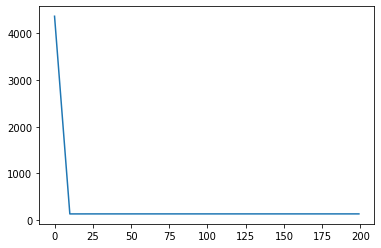

In [30]:
plt.plot(history_validation["epoch"],
         history_validation["greedy_cer"], label="greedy")
plt.plot(history_validation["epoch"],
         history_validation["viterbi_cer"], label="viterbi")
plt.legend()

In [ ]:
plt.plot(history_validation["epoch"],
         history_validation["greedy_wer"], label="greedy")
plt.plot(history_validation["epoch"],
         history_validation["viterbi_wer"], label="viterbi")
plt.legend()

In [ ]:
plt.plot(history_validation["epoch"],
         history_validation["greedy_cer_normalized"], label="greedy")
plt.plot(history_validation["epoch"],
         history_validation["viterbi_cer_normalized"], label="viterbi")
plt.legend()

In [ ]:
plt.plot(history_validation["epoch"],
         history_validation["greedy_wer_normalized"], label="greedy")
plt.plot(history_validation["epoch"],
         history_validation["viterbi_wer_normalized"], label="viterbi")
plt.legend()

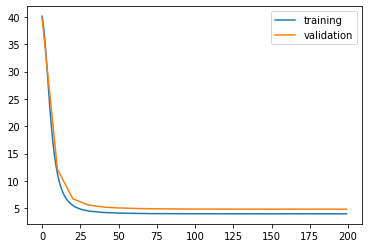

In [34]:
plt.plot(history_training["epoch"],
         history_training["sum_loss"], label="training")
plt.plot(history_validation["epoch"],
         history_validation["sum_loss"], label="validation")
plt.legend()

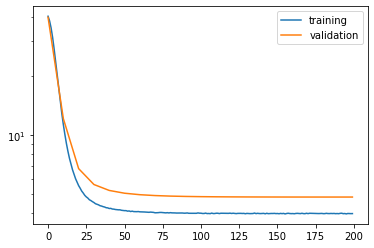

In [35]:
plt.plot(history_training["epoch"],
         history_training["sum_loss"], label="training")
plt.plot(history_validation["epoch"],
         history_validation["sum_loss"], label="validation")
plt.yscale("log")
plt.legend()

In [36]:
print(torch.cuda.memory_summary(), flush=True)

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  102506 KB |    7892 MB |  627864 GB |  627864 GB |
|       from large pool |  101956 KB |    7891 MB |  627407 GB |  627407 GB |
|       from small pool |     550 KB |       2 MB |     457 GB |     457 GB |
|---------------------------------------------------------------------------|
| Active memory         |  110128 KB |    7892 MB |  627864 GB |  627864 GB |
|       from large pool |  109578 KB |    7891 MB |  627407 GB |

In [37]:
# Print performance
pr.disable()
s = StringIO()
ps = (
    pstats
    .Stats(pr, stream=s)
    .strip_dirs()
    .sort_stats("cumtime")
    .print_stats(20)
)
print(s.getvalue(), flush=True)
print("stop time: {}".format(str(datetime.now())), flush=True)

         434272777 function calls (429946959 primitive calls) in 57949.714 seconds

   Ordered by: cumulative time
   List reduced from 3109 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       37    0.001    0.000 57949.623 1566.206 base_events.py:1686(_run_once)
   155/29    0.001    0.000 42534.115 1466.694 gen.py:716(run)
   254/80    0.000    0.000 42534.115  531.676 {method 'send' of 'generator' objects}
   197/65    0.002    0.000 42534.109  654.371 gen.py:184(wrapper)
      165    0.000    0.000 42534.105  257.782 kernelbase.py:347(process_one)
       98    0.002    0.000 42534.102  434.021 kernelbase.py:225(dispatch_shell)
128857/157    0.139    0.000 42534.059  270.918 {built-in method builtins.next}
      436    0.000    0.000 42534.031   97.555 events.py:86(_run)
      436    0.000    0.000 42534.031   97.555 {method 'run' of 'Context' objects}
      287    0.000    0.000 42534.029  148.202 ioloop.py:735(_run_callback